In [32]:
import os

import tonic
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
nmnist = tonic.datasets.NMNIST("data/", train=False)
cifar10dvs = tonic.datasets.CIFAR10DVS("data/")
# asldvs = tonic.datasets.ASLDVS("data/")
dvsgesture = tonic.datasets.DVSGesture("data/", train=False)
ncaltech101 = tonic.datasets.NCALTECH101("data/")
# poker_dvs = tonic.datasets.POKERDVS("data/", train=False)
# # smnist = tonic.datasets.SMNIST("data/", train=False)  # will not be used
# dvslip = tonic.datasets.DVSLip("data/", train=False)

In [ ]:
import struct


def load_aedat(filepath: str) -> dict[str, np.ndarray]:
    """
    Load events from an AEDAT file (version 2).
    
    Args:
        filepath: Path to the .aedat file
        
    Returns:
        Dictionary containing 'x', 'y', 'timestamp', and 'polarity' arrays
    """
    with open(filepath, 'rb') as f:
        # Skip header lines starting with '#'
        while True:
            position = f.tell()
            line = f.readline()
            if not line.startswith(b'#'):
                f.seek(position)
                break
        
        # Read binary event data
        events = []
        while True:
            data = f.read(8)  # Each event is 8 bytes
            if len(data) < 8:
                break
            
            # Unpack event data
            addr, timestamp = struct.unpack('II', data)
            
            # Extract x, y, polarity from address
            x = (addr >> 12) & 0x3FF
            y = (addr >> 22) & 0x3FF
            polarity = (addr >> 11) & 0x1
            
            events.append([x, y, timestamp, polarity])
    
    if not events:
        return {
            'x': np.array([]),
            'y': np.array([]),
            'timestamp': np.array([]),
            'polarity': np.array([])
        }
    
    events_array = np.array(events)
    
    return {
        'x': events_array[:, 0].astype(np.int16),
        'y': events_array[:, 1].astype(np.int16),
        'timestamp': events_array[:, 2].astype(np.uint32),
        'polarity': events_array[:, 3].astype(np.bool_)
    }

In [37]:
poker_dvs_path = "data/poker_dvs"

poker_dvs_files = [f for f in os.listdir(poker_dvs_path) if f.endswith(".aedat")]

poker_dvs_filepath = os.path.join(poker_dvs_path, poker_dvs_files[0])

data = load_aedat(poker_dvs_filepath)

In [41]:
data['polarity'].sum()

np.int64(0)

In [ ]:
datasets = {
    "nmnist": nmnist,
    "cifar10dvs": cifar10dvs,
    # "asldvs": asldvs,
    "dvsgesture": dvsgesture,
    "ncaltech101": ncaltech101,
    # "poker_dvs": poker_dvs,
    # "dvslip": dvslip,
}

datasets_metadata = {
    "nmnist": {
        "denoise": 1200,
        "event_count": 1500,
    },
    "cifar10dvs": {
        "denoise": 5000,
        "event_count": 20000,
    },
    # "asldvs": {
    #     "denoise": 8000,
    #     "event_count": 30000,
    # },
    "dvsgesture": {
        "denoise": 10000,
        "event_count": 40000,
    },
    "ncaltech101": {
        "denoise": 5000,
        "event_count": 40000,
    },
    # "poker_dvs": {
    #     "denoise": 1500,
    #     "event_count": 8000,
    # },
    # "dvslip": {
    #     "denoise": 3000,
    #     "event_count": 10000,
    # },
}

In [22]:
def plot_examples(name, dataset, metadata, num_examples=5, seed=0):

    np.random.seed(seed)
    indices = np.random.choice(len(dataset), num_examples, replace=False)

    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))
    for i, idx in enumerate(indices):
        events, label = dataset[idx]

        transform = tonic.transforms.Compose(
            [
                tonic.transforms.Denoise(filter_time=metadata["denoise"]),
                tonic.transforms.ToFrame(
                    sensor_size=dataset.sensor_size,
                    event_count=metadata["event_count"],
                    overlap=int(0.75 * metadata["event_count"]),
                ),
            ]  # type: ignore
        )

        frames = transform(events)

        # plot the first frame with positive events in blue and negative events in red
        axes[0, i].imshow(frames[0, 0], cmap="Blues") # positive events
        axes[1, i].imshow(frames[0, 1], cmap="Reds", alpha=0.5) # negative events
        
        if i == num_examples // 2:
            axes[0, i].set_title(f"{name} - Label: {label}")
        else:
            axes[0, i].set_title(f"Label: {label}")
        
        axes[0, i].axis(False)
        axes[1, i].axis(False)
    fig.tight_layout()

plt.show()

ValueError: no field of name y

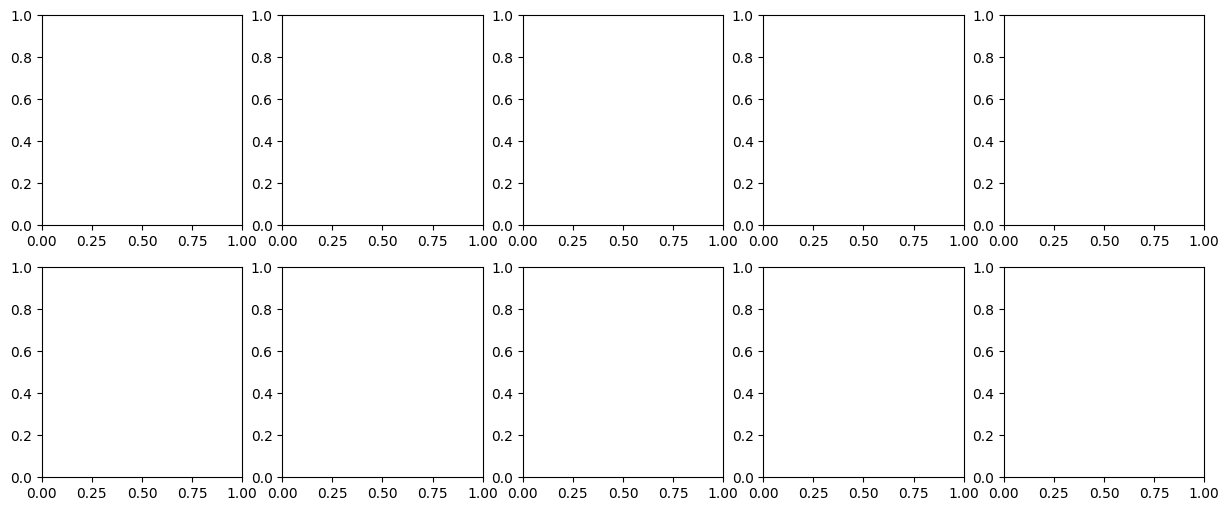

In [28]:
# for name, dataset, metadata in zip(
#     datasets.keys(), datasets.values(), datasets_metadata.values()
# ):
#     plot_examples(name, dataset, metadata)

dataset_name = "smnist"
plot_examples(dataset_name, datasets[dataset_name], datasets_metadata[dataset_name], num_examples=5, seed=42)